<a href="https://colab.research.google.com/github/Ragnarok540/sympy-tutorial/blob/main/ising_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# https://www.youtube.com/watch?v=K--1hlv9yv0
# https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/

import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from PIL import Image
from ipywidgets import interact

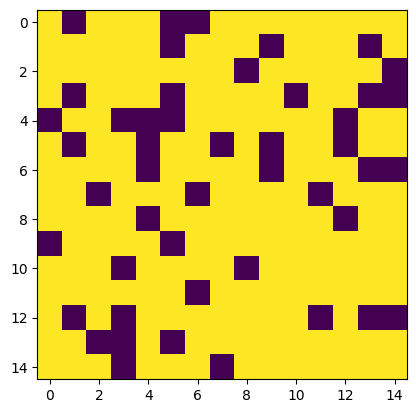

In [6]:
n = 15

init_random = np.random.random((n, n))
lattice_n = np.zeros((n, n))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((n, n))
lattice_p = np.zeros((n, n))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

plt.imshow(lattice_p)

In [7]:
def get_energy(lattice):
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

get_energy(lattice_p)

np.float64(-260.0)

In [11]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times - 1)
    net_energy = np.zeros(times - 1)

    for t in range(0, times - 1):
        x = np.random.randint(0, n)
        y = np.random.randint(0, n)
        spin_i = spin_arr[x, y]
        spin_f = spin_i *- 1

        e_i = 0
        e_f = 0

        if x > 0:
            e_i += -spin_i * spin_arr[x - 1, y]
            e_f += -spin_f * spin_arr[x - 1, y]

        if x < n - 1:
            e_i += -spin_i * spin_arr[x + 1, y]
            e_f += -spin_f * spin_arr[x + 1, y]

        if y > 0:
            e_i += -spin_i * spin_arr[x, y - 1]
            e_f += -spin_f * spin_arr[x, y - 1]

        if y < n - 1:
            e_i += -spin_i * spin_arr[x, y + 1]
            e_f += -spin_f * spin_arr[x, y + 1]

        dE = e_f - e_i

        if (dE > 0) * (np.random.random() < np.exp(-BJ * dE)):
            spin_arr[x, y] = spin_f
            energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            energy += dE

        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy

    return net_spins, net_energy

/usr/local/lib/python3.11/dist-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


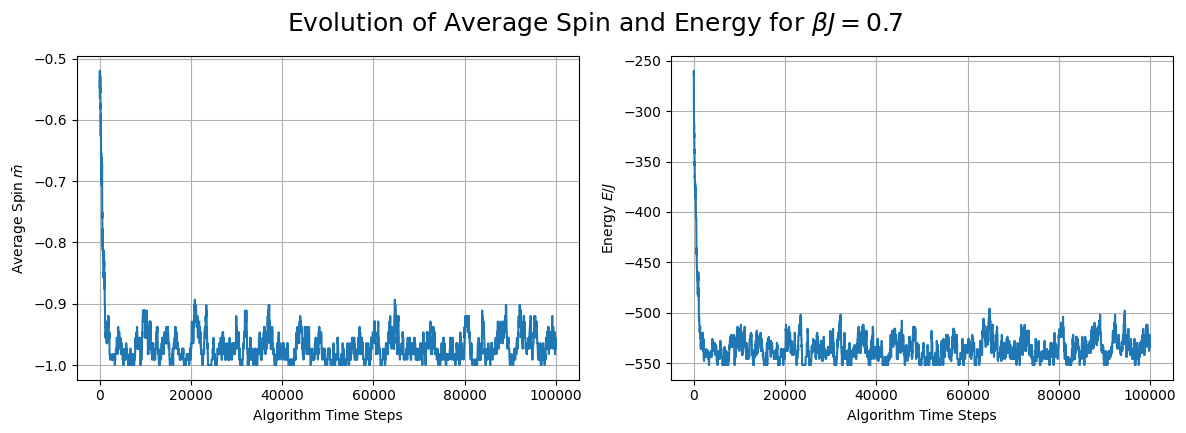

In [15]:
spins, energies = metropolis(lattice_n, 100000, 0.7, get_energy(lattice_n))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins / n**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7', y=1.07, size=18)
plt.show()

In [16]:
def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

random_spin_field(10, 10)

array([[-1, -1, -1,  1, -1,  1, -1, -1,  1, -1],
       [ 1,  1, -1,  1, -1, -1, -1,  1, -1,  1],
       [ 1, -1, -1, -1, -1,  1,  1,  1, -1, -1],
       [-1,  1, -1,  1,  1, -1,  1,  1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1,  1, -1,  1],
       [-1, -1, -1, -1,  1,  1, -1,  1, -1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1],
       [-1, -1, -1,  1,  1,  1, -1, -1, -1, -1],
       [-1,  1,  1,  1, -1,  1, -1, -1,  1, -1],
       [-1, -1,  1, -1,  1,  1,  1,  1,  1,  1]])

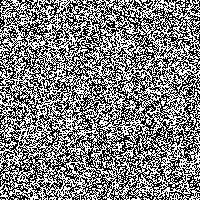

In [18]:
def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))

display_spin_field(random_spin_field(200, 200))

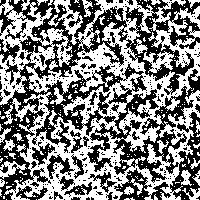

In [19]:
def ising_step(field, beta=0.4):
    N, M = field.shape

    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)

    return field

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape

    for i in range(n - 1, n + 2):
        for j in range(m - 1, m + 2):
            if i == n and j == m:
                continue

            total += field[i % N, j % M]

    dE = 2 * field[n, m] * total

    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

display_spin_field(ising_step(random_spin_field(200, 200)))

In [21]:
def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [ ]:
images = [random_spin_field(200, 200)]

for i in range(50):
    images.append(ising_step(images[-1].copy()))

display_ising_sequence(images);